# **Statistical Arbitrage and Optimal Trading Strategies**

This notebook presents the analysis and implementation of statistical arbitrage techniques, with a focus on optimal trading strategies based on Ornstein-Uhlenbeck (OU) processes. The framework is inspired by Baviera & Santagostino (2019), and aims to replicate and extend their results using Python.

We work with high-frequency financial data and apply a combination of maximum likelihood estimation, bootstrapping techniques, and closed-form solutions to derive optimal trading bands.

The core model assumes the spread between a pair of assets follows an Ornstein-Uhlenbeck (OU) process:

$$
dX_t = \lambda (\theta - X_t) dt + \sigma dW_t
$$

where:

- **X_t** is the spread process  
- **λ** is the speed of mean reversion  
- **θ** is the long-term mean level  
- **σ** is the volatility  
- **W_t** is a standard Brownian motion

Our goal is to determine the optimal entry and exit points that maximize expected returns, while incorporating transaction costs and risk management constraints such as stop-losses and leverage control.

---

*Note: All simulations, estimations, and results are derived in Python, reproducing the structure and insights of the original MATLAB implementation.*

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

from utilities.Data_Ordering import (
    load_and_process_price_data,
    trim_and_split_price_table,
    remove_outliers,
)

from utilities.Statistical_Bootstrap import (
    ou_bootstrap,
    print_ou_estimates,
    plot_bootstrap_distributions,
    plot_optimal_trading_bands,
    plot_CI_mu,
)

from utilities.Optimal_Bands import (
    optimal_trading_bands,
)

### **Data Loading, Preprocessing, and Cleaning**

In this section, we load and preprocess the **Heating Oil (HO)** and **Low-Sulfur Gasoil (LGO)** futures price data from the Excel file `HO-LGO.xlsm`. The raw dataset contains bid and ask prices for each asset.

#### 1. Data Loading and Unit Conversion

We use the `load_and_process_price_data()` function to:

- Load bid and ask quotes for:
  - `HOc2`: Heating Oil (delivered in gallons, converted to barrels via a factor of 42)
  - `LGOc6`: Gasoil (quoted in metric tons, converted using factor $1/7.44$)
- Apply unit conversions to ensure price comparability
- Restrict the time range to:  
  **22 April 2015 – 22 April 2016**

#### 2. Dataset Splitting

Using `trim_and_split_price_table()`, we partition the data into:

- **In-Sample (IS)**: first 9 months of data
  - Time windows tested: 08:00–16:00 and 09:00–16:00
- **Out-of-Sample (OS)**: final 3 months of data
  - Time window: all day without 17:00–20:00

This allows for model calibration on IS data and validation on unseen OS data.

#### 3. Outlier Detection and Removal

Statistical outliers are removed using `remove_outliers()` applied to each dataset:

- IS dataset (08:00–16:00)
- IS dataset (09:00–16:00)
- OS dataset (all day without 17:00–20:00)

Outliers are stored separately for inspection, and boolean masks (`mask_IS`, `mask_OS`) are retained if needed for further filtering.

#### 4. Outlier Summary

The first few detected outliers from each cleaned dataset are printed for inspection to verify that the cleaning procedure has worked properly.

In [2]:
# Load and preprocess futures data from Excel (HO = Heating Oil, LGO = Low-Sulfur Gasoil)
tbl = load_and_process_price_data(
    filepath="HO-LGO.xlsm",
    time_col='nan_Timestamp',
    bid_ask_cols=['HOc2_Bid Close', 'HOc2_Ask Close', 'LGOc6_Bid Close', 'LGOc6_Ask Close'],
    mid_cols=None,
    ticks=None,
    convs=[42, 1/7.44],  # Unit conversions: HO (gallons), LGO (metric tons)
    start_date='2015-04-22',
    end_date='2016-04-22'
)

# Split data into In-Sample (IS) and Out-of-Sample (OS) sets based on time of day and first 9 months
data_IS_8_16, data_OS = trim_and_split_price_table(
    tbl,
    IS_start_hour=8, IS_end_hour=16,
    OS_start_hour=17, OS_end_hour=20,
    split_months=9
)

data_IS_9_16, _ = trim_and_split_price_table(
    tbl,
    IS_start_hour=9, IS_end_hour=16,
    OS_start_hour=17, OS_end_hour=20,
    split_months=9
)

# Remove statistical outliers from IS and OS datasets
clean_data_IS_8_16, outliers_IS_8_16, mask_IS = remove_outliers(data_IS_8_16)

clean_data_IS_9_16, outliers_IS_9_16, mask_IS = remove_outliers(data_IS_9_16)

clean_data_OS, outliers_OS, mask_OS = remove_outliers(data_OS)

# Show detected outliers
print("\nOutliers in IS dataset for 8-16:")
print(outliers_IS_8_16.head())

print("\nOutliers in IS dataset for 9-16:")
print(outliers_IS_9_16.head())

print("\nOutliers in OS dataset:")
print(outliers_OS.head())



<class 'pandas.core.series.Series'>

Outliers in IS dataset for 8-16:
                   Time   Bid1    Ask1    Mid1      Bid2      Ask2       Mid2  \
887 2015-07-03 12:30:00  76.02  82.068  79.044  76.71371  76.88172  76.797715   

          Rt  
887  0.02883  

Outliers in IS dataset for 9-16:
                   Time   Bid1    Ask1    Mid1      Bid2      Ask2       Mid2  \
781 2015-07-03 12:30:00  76.02  82.068  79.044  76.71371  76.88172  76.797715   

          Rt  
781  0.02883  

Outliers in OS dataset:
                   Time    Bid1     Ask1     Mid1       Bid2       Ask2  \
723 2016-02-15 20:00:00  46.557  46.6032  46.5801  46.236559  46.337366   

          Mid2        Rt  
723  46.286962  0.006313  


/Users/giacomokirn/PoliMi/Energy-Trading/Energy-Trading-Python/utilities/Data_Ordering.py:11: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  first_row = df_raw.iloc[row1].fillna(method='ffill').astype(str)


### (a) Sensitivity of Optimal Trading Bands to Transaction Costs

In this section, we analyze how the **optimal trading bands** — specifically, the entry and exit levels $d^*$ and $u^*$ — vary with increasing **transaction costs** $C$.

We consider a **theoretical scenario** where the parameters of the Ornstein-Uhlenbeck process are fixed as:

- $\theta = 1.0$: speed of mean reversion
- $\mu = 0.0$: long-run mean (centered)
- $\sigma = 1.0$: volatility

The OU parameters are stored in a dictionary `G` which mimics the structure used in empirical bootstrap outputs.

#### Configuration

- $M = 1$: no bootstrap sampling, use fixed parameters only
- $l = -1.96$: stop-loss level (in $\sigma$-units)
- $f = 1$: fixed leverage
- $\alpha = 0.95$: confidence level

We vary the transaction cost $C$ over a range of values — not in standard deviation units, but in natural scale — from 0 to a maximum defined by:

$$
C_{\text{max}} = 0.76 \cdot \frac{\sigma}{\sqrt{2 \theta}} = 0.76 \cdot \frac{1}{\sqrt{2}} \approx 0.537
$$

This ensures that we remain in a meaningful range for cost sensitivity analysis.

#### Output

For each value of $C$ in this range, we compute the corresponding optimal bands:

- $d^*$: entry level (lower bound)
- $u^*$: exit level (upper bound)

These are stored and plotted as a function of $C$ using `plot_optimal_trading_bands()`.

The resulting plot helps us understand how increasing transaction costs lead to **wider no-trading regions**, as the cost of entering/exiting a position rises and more price deviation is needed to justify trading.

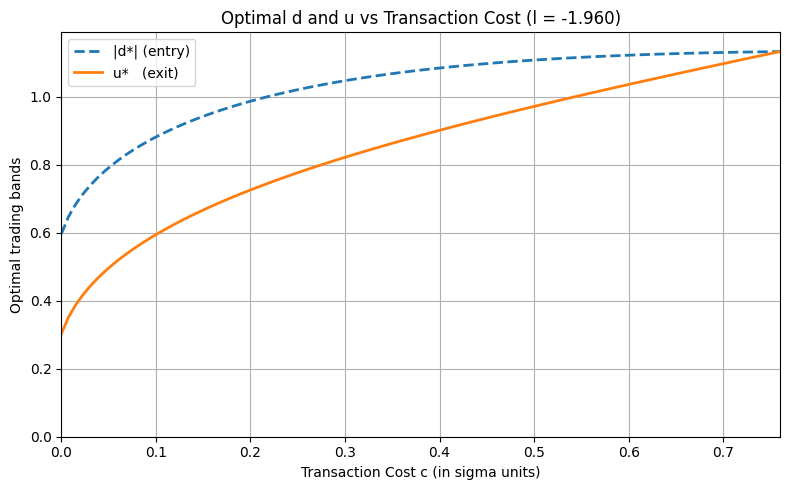

In [3]:
M     = 1             # no bootstrap
l     = -1.96         # stop-loss in σ-units
f     = 1             # fixed leverage = 1
alpha = 0.95          # confidence level

k_val = 1.0
sigma_val = 1.0
grid = 100

G = {
    'parameters': pd.DataFrame([[k_val, 0.0, sigma_val]],
                                columns=['k','eta','sigma']),
    'bootstrap_params': pd.DataFrame([[k_val, 0.0, sigma_val]] * M,
                                     columns=['k','eta','sigma'])
}

n_points    = 100
c_sigma_max = 0.76

# “Natural” C values (not in σ-units):
c_values = np.linspace(
    0,
    c_sigma_max * sigma_val / np.sqrt(2 * k_val),
    n_points
)

d_opt = np.zeros(n_points)
u_opt = np.zeros(n_points)

for i, C in enumerate(c_values):
    R = optimal_trading_bands(M, l, f, G, C, alpha, grid=grid)
    d_opt[i] = R['d_estimated']
    u_opt[i] = R['u_estimated']

plot_optimal_trading_bands(c_values, d_opt, u_opt, l,
                           k_val=k_val, sigma_val=sigma_val,
                           c_sigma_max=0.76)

### **(b) Bootstrap Estimation of OU Parameters**

In this section, we estimate the parameters of the **Ornstein-Uhlenbeck (OU)** process using **nonparametric bootstrap** on two filtered in-sample datasets:
- IS dataset from 08:00 to 16:00 (`clean_data_IS_8_16`)
- IS dataset from 09:00 to 16:00 (`clean_data_IS_9_16`)

The OU process is commonly used to model mean-reverting behavior and is given by the stochastic differential equation:

$$
dX_t = \theta (\mu - X_t)dt + \sigma dW_t
$$

Where:
- $\theta$: speed of mean reversion  
- $\mu$: long-term mean  
- $\sigma$: volatility  
- $W_t$: standard Brownian motion

We apply the function `ou_bootstrap()` to each dataset to estimate these parameters with **confidence intervals** obtained through resampling.

#### Procedure

1. **Bootstrap Sampling**: Resample the residuals and re-estimate the parameters across many repetitions.
2. **Estimation Outputs**:
   - Point estimates for $\theta$, $\mu$, $\sigma$
   - Empirical distributions (from bootstrap)
   - Visualization of uncertainty via `plot_bootstrap_distributions`

#### Results

- **IS dataset (08:00–16:00)**  
  `parameters_8_16 = ou_bootstrap(clean_data_IS_8_16)`  
  Bootstrap plots with $M = 1000$ resamples

- **IS dataset (09:00–16:00)**  
  `parameters_9_16 = ou_bootstrap(clean_data_IS_9_16)`  
  Bootstrap plots with $M = 10000$ resamples (higher precision)

Each estimate is displayed using the `print_ou_estimates()` function, followed by a visualization of the bootstrap distributions for each parameter.

These estimates are fundamental for computing the optimal trading bands in the following sections, as they quantify the mean-reverting dynamics of the spread process.


Estimates for IS dataset (8-16):
Ornstein-Uhlenbeck Parameter Estimates
---------------------------------------------
k     : Estimate = 23.906589, 95% CI = [15.020562, 52.725183]
eta   : Estimate = -0.009804, 95% CI = [-0.019615, 0.000653]
sigma : Estimate = 0.103173, 95% CI = [0.100681, 0.105541]


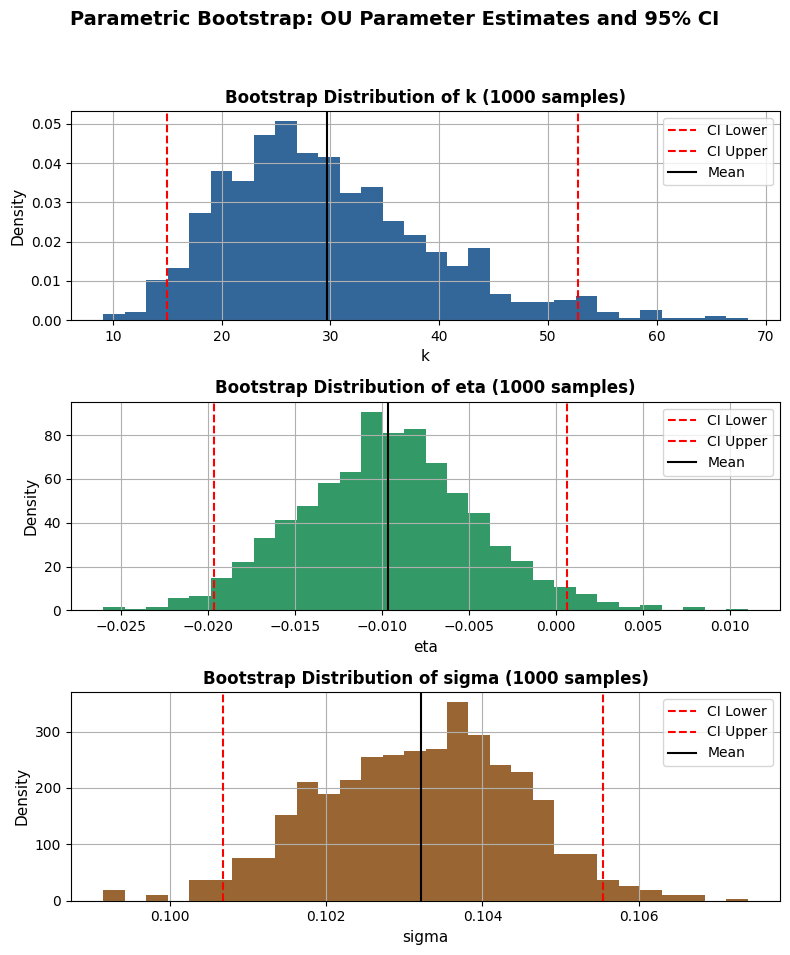


Estimates for IS dataset (9-16):
Ornstein-Uhlenbeck Parameter Estimates
---------------------------------------------
k     : Estimate = 23.602388, 95% CI = [14.685158, 54.482336]
eta   : Estimate = -0.009772, 95% CI = [-0.019290, 0.000702]
sigma : Estimate = 0.102253, 95% CI = [0.099877, 0.104840]


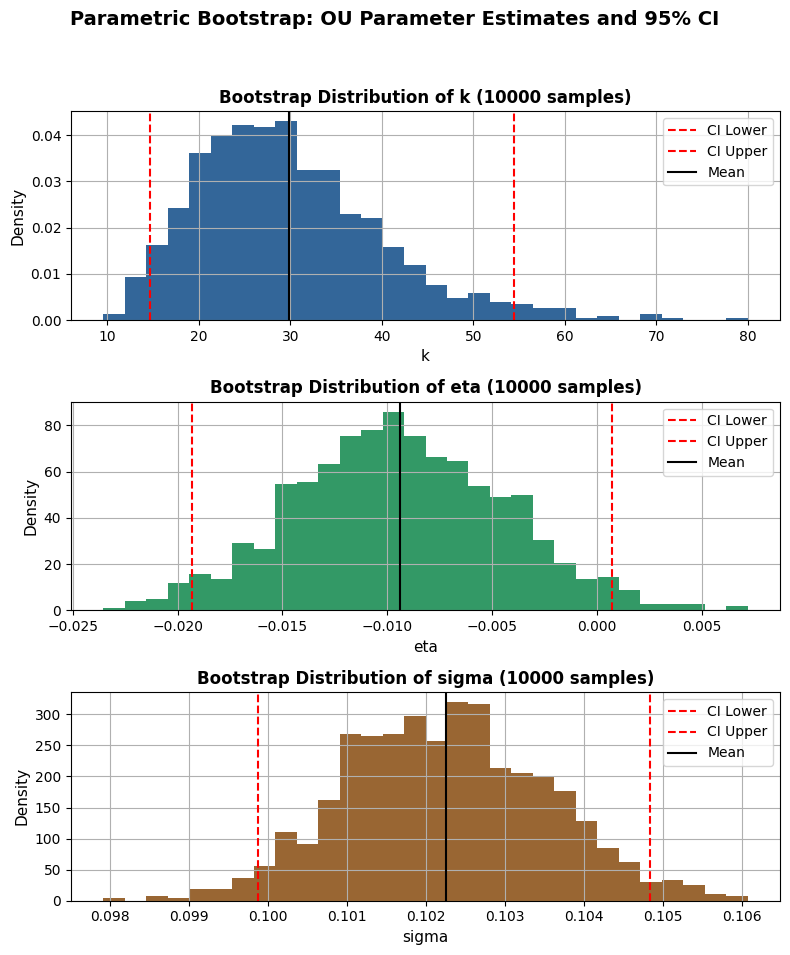

In [4]:
np.random.seed(42)  # For reproducibility

# Estimate OU parameters using bootstrap for the filtered 8–16 IS dataset

parameters_8_16 = ou_bootstrap(clean_data_IS_8_16)
print("\nEstimates for IS dataset (8-16):")
print_ou_estimates(parameters_8_16)
plot_bootstrap_distributions(parameters_8_16, M=1000)

# Estimate OU parameters using bootstrap for the filtered 9-16 IS dataset

parameters_9_16 = ou_bootstrap(clean_data_IS_9_16)
print("\nEstimates for IS dataset (9-16):")
print_ou_estimates(parameters_9_16)
plot_bootstrap_distributions(parameters_9_16, M=10000)

### **(c)–(e) Optimal Trading Bands with Transaction Costs**

In this section, we compute the **average log transaction cost** associated with bid-ask spreads, and evaluate the performance of different **stop-loss levels** and **leverage values** in the optimal trading band strategy.

#### Log Transaction Cost

The transaction cost at each time $t$, denoted $C_t$, is computed as the sum of the log bid-ask spreads for the two instruments:

$$
C_t = \log\left(\frac{\text{Ask1}_t}{\text{Bid1}_t}\right) + \log\left(\frac{\text{Ask2}_t}{\text{Bid2}_t}\right)
$$

We then define the average transaction cost $C$ as:

$$
C = \mathbb{E}[C_t]
$$

#### Parameters

We test multiple **stop-loss levels** $l$ (expressed in units of standard deviation) and **leverage values** $f$. The stop-loss levels considered are:

$$
l \in \{-1.282, -1.645, -1.96, -2.326\}
$$

and the leverage values tested are:

$$
f \in \{1, 2, 5, \text{"opt"}\}
$$

Here, `"opt"` indicates that the leverage is not fixed, but rather **optimized** within the strategy.

We set:
- $M = 100000$: a large number of bootstrap samples is used to compute confidence intervals.
- $\alpha = 0.05$: confidence level for the intervals of $d^*$, $u^*$, $\mu$, and $f^*$.

#### Output

For each pair $(l, f)$, the function `optimal_trading_bands` returns:
- the **optimal entry and exit bands** $(d^*, u^*)$,
- the **long-run mean return** $\mu$,
- and — if $f = \text{"opt"}$ — the **optimal leverage** $f^*$,

as well as the associated **confidence intervals**.

The results are collected in the following table:

| Stop-loss | Leverage | $d^*$ | CI($d^*$) | $u^*$ | CI($u^*$) | $\mu$ | CI($\mu$) | $f^*$ (if optimized) | CI($f^*$) |
|-----------|----------|--------|-------------|--------|-------------|--------|-------------|----------------------|-------------|
| ...       | ...      | ...    | [low, high] | ...    | [low, high] | ...    | [low, high] | ...                  | [low, high] |

This table allows us to analyze how different combinations of stop-loss and leverage affect the strategy’s trading bands and long-term profitability.

#### Confidence Interval Visualization

The following plot shows the long-run return $\mu$ for each stop-loss level under **optimized leverage**, with shaded **95% confidence intervals** computed using bootstrap:

```python
plot_CI_mu(df_results[df_results['Leverage'] == 'opt'], alpha)

 Stop-loss Leverage       d*  d_CI_low  d_CI_high       u*  u_CI_low  u_CI_high        μ  mu_CI_low  mu_CI_high         f*   f_CI_low  f_CI_high
    -1.282        1 0.754961  0.717547   0.775221 0.554101  0.529578   0.612585 0.049384   0.038986    0.051231                                 
    -1.282        2 0.753894  0.717556   0.773394 0.537832  0.507909   0.603657 0.092627   0.071901    0.096085                                 
    -1.282        5 0.754450  0.717806   0.773603 0.492419  0.448688   0.575447 0.187371   0.132830    0.193860                                 
    -1.282      opt 0.762120  0.719429   0.786265 0.433210  0.372436   0.558388 0.238074   0.144606    0.246508   9.450311   6.985004   9.553367
    -1.645        1 0.922103  0.913877   0.932354 0.599287  0.573861   0.643608 0.104850   0.087682    0.133933                                 
    -1.645        2 0.918523  0.908409   0.930448 0.580555  0.549202   0.641259 0.203130   0.169019    0.261106                   

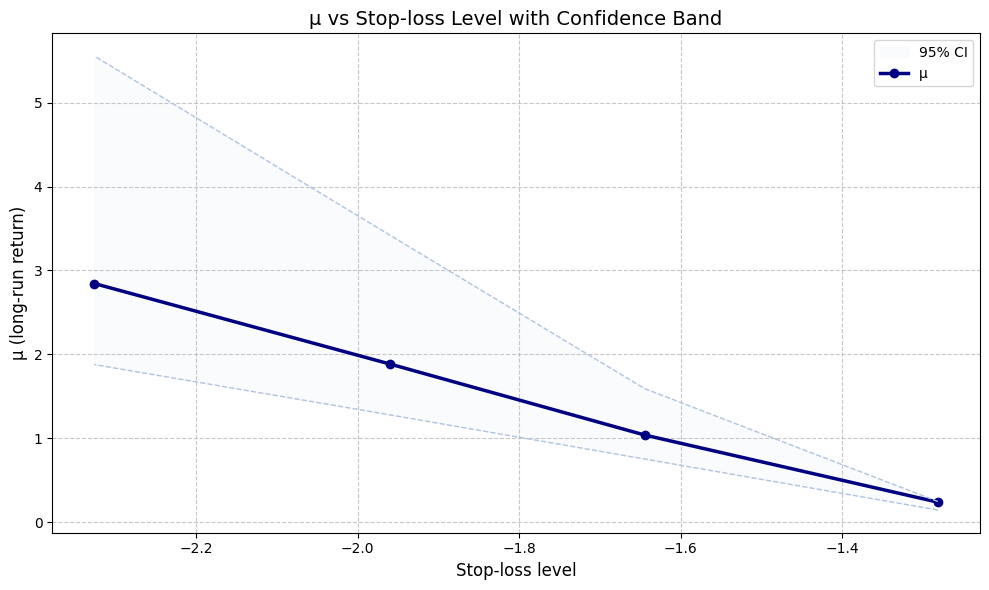

In [5]:
# Compute transaction costs (log-bid/ask spreads)
C_t = np.log(data_IS_9_16['Ask1'] / data_IS_9_16['Bid1']) + \
      np.log(data_IS_9_16['Ask2'] / data_IS_9_16['Bid2'])

C = np.mean(C_t)  # average log transaction cost

l_list = [-1.282, -1.645, -1.96, -2.326]        # stop-loss levels in σ-units
f_list = [1, 2, 5, 'opt']                       # leverage to test
M      = 100000                                   
alpha  = 0.05                                   # confidence level
grid   = 100                                    # number of points in sigma grid

results = []

for l in l_list:
    for f in f_list:
        R = optimal_trading_bands(M=M, l=l, f=f, P=parameters_8_16, C=C, alpha=alpha, grid=grid)
        row = {
            "Stop-loss": l,
            "Leverage": f,
            "d*": R['d_estimated'],
            "d_CI_low": R['d_CI'][0],
            "d_CI_high": R['d_CI'][1],
            "u*": R['u_estimated'],
            "u_CI_low": R['u_CI'][0],
            "u_CI_high": R['u_CI'][1],
            "μ": R['mu_estimated'],
            "mu_CI_low": R['mu_CI'][0],
            "mu_CI_high": R['mu_CI'][1],
            "f*": R['f_estimated'] if f == 'opt' else '',
            "f_CI_low": R['f_opt_CI'][0] if f == 'opt' else '',
            "f_CI_high": R['f_opt_CI'][1] if f == 'opt' else '',
        }
        results.append(row)

df_results = pd.DataFrame(results)
print(df_results.to_string(index=False))

plot_CI_mu(df_results[df_results['Leverage'] == 'opt'], alpha)

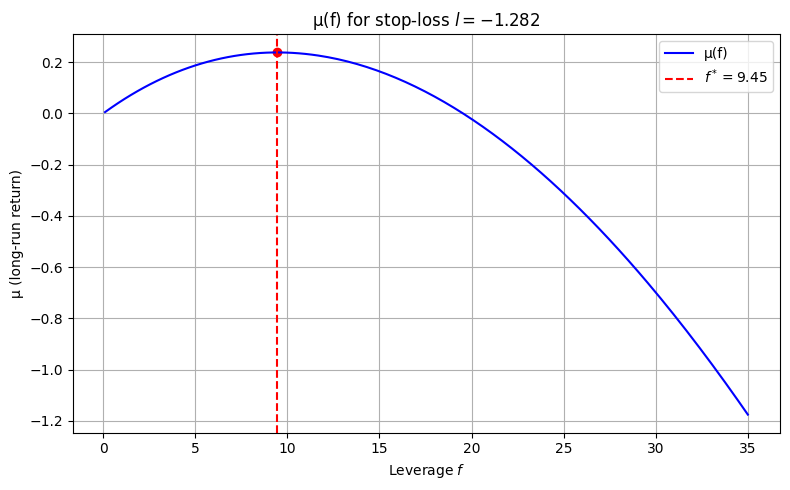

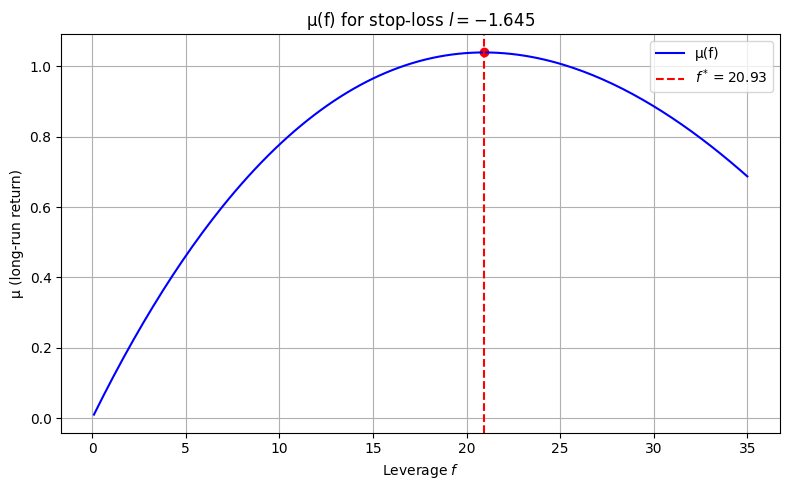

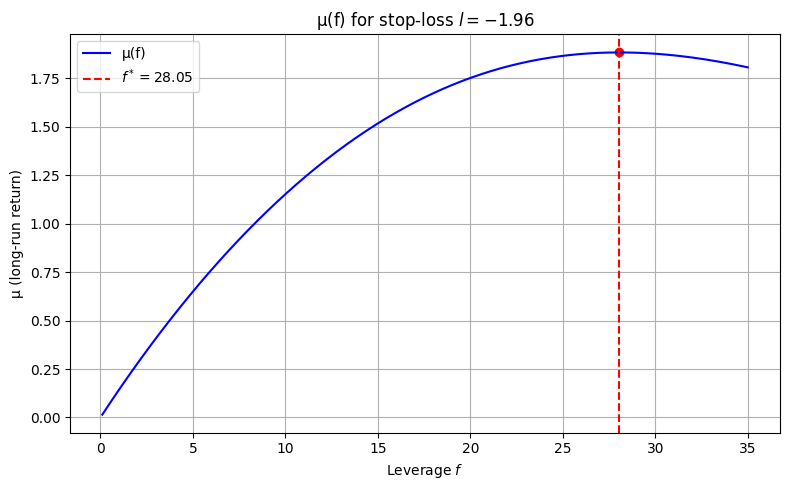

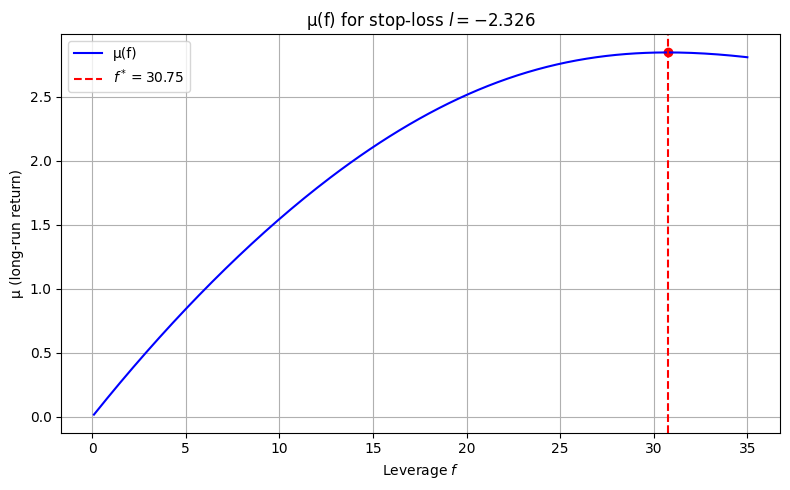

In [6]:
f_grid = np.linspace(0.1, 35, 200)

for l in l_list:
    mu_values = []

    # OU parameters from the 8-16 IS dataset
    k_hat = parameters_8_16['parameters']['k'].values[0]
    sigma_hat = parameters_8_16['parameters']['sigma'].values[0]
    theta = 1 / k_hat
    sigma_stat = sigma_hat / np.sqrt(2 * k_hat)
    c = C / sigma_stat

    # Compute mu(f) for each f
    for f in f_grid:
        R = optimal_trading_bands(M=1, l=l, f=f, P=parameters_8_16, C=C, alpha=alpha, grid=grid)
        mu_values.append(R['mu_estimated'])

    R_opt = optimal_trading_bands(M=1, l=l, f='opt', P=parameters_8_16, C=C, alpha=alpha, grid=grid)
    f_star = R_opt['f_estimated']
    mu_star = R_opt['mu_estimated']

    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(f_grid, mu_values, label='μ(f)', color='blue')
    plt.axvline(f_star, color='red', linestyle='--', label=f'$f^* = {f_star:.2f}$')
    plt.scatter([f_star], [mu_star], color='red')
    plt.xlabel("Leverage $f$")
    plt.ylabel("μ (long-run return)")
    plt.title(f"μ(f) for stop-loss $l = {l}$")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()